**Author: Haggi Ilombo**


**Date: December 2025**

# **Predictive Modeling of Income Classification Using an Optimized Random Forest Algorithm and Feature Importance Analysis**

## **Data Source**
The dataset utilized for this project is the Census Income of the 1994 Census, obtained from the UC Irvine Machine Learning Repository website (a link to the repository is provided below).

This dataset has been previously employed by researchers, leveraging various models such as Logistic Regression, Neural Networks, and Random Forest, to predict whether an individual's annual income exceeds or falls below $$50,000.

**Link to the website:** https://archive.ics.uci.edu/dataset/2/adult

## **Objective:**

This analysis will initially employ a Random Forest classification model to perform the aforementioned prediction task on the dataset. Subsequently, feature engineering techniques will be utilized to strategically optimize key performance metrics—specifically Accuracy, Precision, Recall, and the F1 Score—on a refined model.

Finally, the performance and feature importance derived from the refined model will be analyzed and compared against both the initial model and the findings documented in the original research.

The project will conclude with a discussion regarding the handling of class imbalances, a summary of the most significant features, and a reflection on the model's strengths and limitations.


# **Section I: Preprocessing**
Section one involves loading the 'adult.data' and 'adult.test' datasets, assigning column names, and reading the training and test files. During this process, raw "?" markers are converted to appropriate missing values using the `na_values` parameter.

Subsequently, the script employs dropna() to eliminate all rows containing incomplete data, a process confirmed by the output of` isnull().any().any()`.

Finally, the income labels in the test set (adulttest) are standardized by removing trailing periods to ensure consistency with the training set (adultdata).

**Note to Readers**

Prior data exploration has been completed. This document commences directly with data manipulation, immediately following the data loading stage.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
    ]

adultdata = pd.read_csv("adult.data", names=column_names, na_values=["?"], skipinitialspace=True, header=None)
adulttest = pd.read_csv("adult.test",names=column_names, na_values=["?"], skipinitialspace=True, skiprows=1)

adultdata = adultdata.dropna()
adulttest = adulttest.dropna()

print(adultdata.isnull().any().any())
print(adulttest.isnull().any().any())

False
False


In [3]:
adultdata.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adulttest = adulttest.replace({'<=50K.': '<=50K', '>50K.': '>50K'})
adulttest.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


## **Section II: Building and Executing the Models**



Section two first examines target label distribution, identifies categorical and numerical features, and applies preprocessing using a `ColumnTransformer` (one-hot encoding for categorical, standard scaling for numeric).

A baseline Random Forest model is trained and evaluated using accuracy, precision, recall, and F1-score.

A full pipeline is then constructed, and `RandomizedSearchCV `is used for hyperparameter tuning. The best model is selected and re-evaluated with the initial metrics and visualizing with a confusion matrix.

`OneHotEncoder` ensures categorical data is converted to numerical form, and with missing values already removed, the model can train consistently.

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [6]:
X_train = adultdata.drop("income", axis=1)
y_train = adultdata['income']

X_test = adulttest.drop("income", axis=1)
y_test = adulttest['income']

print(adultdata['income'].value_counts() + adulttest['income'].value_counts())

income
<=50K    34014
>50K     11208
Name: count, dtype: int64


In [7]:
from imblearn.over_sampling import SMOTENC
from collections import Counter

print("Original class distribution (y_train) before SMOTENC:")
print(pd.Series(y_train).value_counts())

cat_cols_smote = X_train.select_dtypes(include=["object"]).columns
cat_features_idx_smote = [X_train.columns.get_loc(col) for col in cat_cols_smote]

smote_nc = SMOTENC(categorical_features=cat_features_idx_smote, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

print("\nNew class distribution after SMOTENC (y_train_resampled):")
print(pd.Series(y_train_resampled).value_counts())

X_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train = pd.Series(y_train_resampled)

cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train_enc, y_train)

y_pred_base = baseline_model.predict(X_test_enc)


Original class distribution (y_train) before SMOTENC:
income
<=50K    22654
>50K      7508
Name: count, dtype: int64

New class distribution after SMOTENC (y_train_resampled):
income
<=50K    22654
>50K     22654
Name: count, dtype: int64


In [8]:
accuracy_tuned = accuracy_score(y_test, y_pred_base)
precision_tuned = precision_score(y_test, y_pred_base, pos_label='>50K')
recall_tuned = recall_score(y_test, y_pred_base, pos_label='>50K')
f1_tuned = f1_score(y_test, y_pred_base, pos_label='>50K')

print(f"Accuracy : {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall   : {recall_tuned:.4f}")
print(f"F1 Score : {f1_tuned:.4f}")

Accuracy : 0.8376
Precision: 0.6614
Recall   : 0.6943
F1 Score : 0.6775


In [9]:
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV

In [10]:
clf = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', clf)
])

param_dist = {
    'model__n_estimators': [200, 500],
    'model__max_depth': [4, 6, 8],
    'model__max_features': ['sqrt', 'log2'],
    'model__criterion': ['gini', 'entropy']
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

search.fit(X_train, y_train)
print(search.best_params_)


{'model__n_estimators': 500, 'model__max_features': 'log2', 'model__max_depth': 8, 'model__criterion': 'gini'}


Accuracy: 0.7765604249667994
Precision: 0.5292372141735032
Recall: 0.8194594594594594
F1 Score: 0.6431222823205006


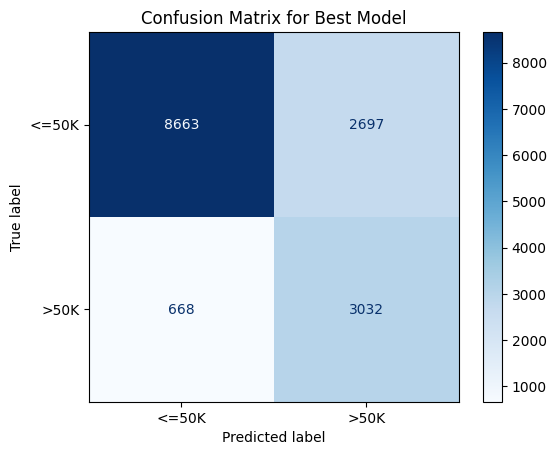

In [11]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='>50K'))
print("Recall:", recall_score(y_test, y_pred, pos_label='>50K'))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='>50K'))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['<=50K', '>50K'],
    cmap='Blues',
    values_format='d'
)
plt.title('Confusion Matrix for Best Model')
plt.show()



## **Section III: Feature Importance**

Section three calculates feature importances by combining one-hot encoded and numeric feature contributions. The top 10 most influential features are identified and visualized in a horizontal bar chart to show their impact on income prediction.

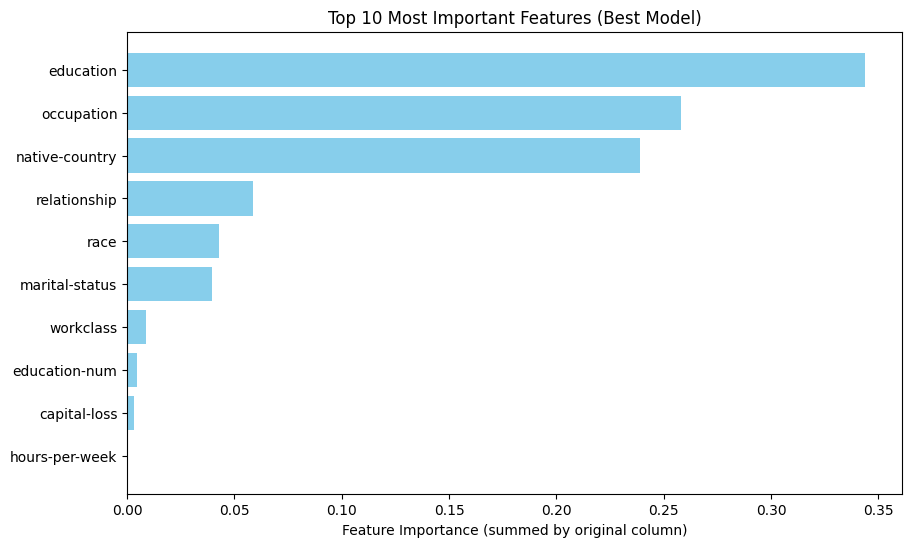

In [12]:

rf_model = best_model.named_steps['model']

cat_ohe_tuned = best_model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = cat_ohe_tuned.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_model.feature_importances_

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feat_imp_df['orig_feature'] = [f.split('_')[0] if '_' in f else f for f in feat_imp_df['feature']]

grouped_importance = feat_imp_df.groupby('orig_feature')['importance'].sum().sort_values(ascending=False)

top10_grouped = grouped_importance.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_grouped.index[::-1], top10_grouped.values[::-1], color='skyblue')
plt.xlabel('Feature Importance (summed by original column)')
plt.title('Top 10 Most Important Features (Best Model)')
plt.show()

## **Section IV: Discussion**
### **Discuss how you handled the imbalance and justify your choice.**

To address the pronounced class imbalance, I implemented the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE was selected because it directly tackles data scarcity for the minority class, which typically biases models toward the majority class. Unlike simpler random oversampling, which risks overfitting by duplicating samples, SMOTE generates new, unique synthetic samples through feature interpolation between minority instances and their nearest neighbors. This process increases training set diversity, ensuring the model learns the minority class's characteristics and resulting in a more robust model with improved generalization.


### **Discuss which features most significantly impact the income classification**

The features that most significantly impact the income classification outcome are: education, occupation, country, relationship, race, marital-status, workclass, education-level, capital-loss, and hours-per-week.


**Interpretation**

The features that most significantly impact income classification are education, occupation, country of origin, relationship status, race, marital status, work class, education level, capital loss, and hours per week.


This model largely aligns with the common understanding of income determinants. Higher education is associated with increased income, as higher-paying occupations often necessitate advanced education.


With native country being the third most impactful feature, this result is consistent with knowledge regarding economic opportunity. A country with a robust economy is typically better positioned to invest in education and provide higher-paying occupations.


### **Reflect on the model’s strengths and any limitations.**

The model tuning significantly improve Recall from 0.6943 to 0.8194, demonstrating an enhanced ability to correctly identify high-income earners. The F1 score of 0.6431 shows a reasonable balance, prioritizing recall.

The key drawback is a drop in Precision from 0.6614 to 0.5292, meaning the model now generates more false positives. This trade-off also lowered Accuracy from 0.8376 to 0.7766, indicating that while the model is better at finding higher earners, the predicted list is noiser.
